In [2]:
import json, pickle
from collections import Counter
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from scipy.sparse import vstack, hstack
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from tqdm import tqdm

warnings.filterwarnings("ignore")

## 1 task

        Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.

In [3]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results = pickle.load(open('chgk/results.pkl', 'rb'))
players = pickle.load(open('chgk/players.pkl', 'rb'))

In [4]:
df_players = pd.DataFrame(players.values()).set_index("id")
df_tournaments = pd.DataFrame(tournaments.values()).set_index("id")

df_tournaments["year"] = df_tournaments["dateStart"].apply(lambda x: int(x[:4]))
df_train_tournaments = df_tournaments[df_tournaments["year"] == 2019]
df_test_tournaments = df_tournaments[df_tournaments["year"] == 2020]

In [6]:
df_train_tournaments.head(10)

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,year
id,,,,,,,,,
4772,Синхрон северных стран. Зимний выпуск,2019-01-05T19:00:00+03:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
4973,Балтийский Берег. 3 игра,2019-01-25T19:05:00+03:00,2019-01-29T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
4974,Балтийский Берег. 4 игра,2019-03-01T19:05:00+03:00,2019-03-05T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
4975,Балтийский Берег. 5 игра,2019-04-05T19:05:00+03:00,2019-04-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
4986,ОВСЧ. 6 этап,2019-02-15T20:00:00+03:00,2019-02-19T20:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
5000,Чёрная Быль,2019-04-26T18:00:00+03:00,2019-04-30T18:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59436, 'name': 'Олег', 'patronymic': '...",{'dateRequestsAllowedTo': '2019-04-30T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
5008,Школьный Синхрон-lite. Выпуск 2.3,2019-01-25T14:00:00+03:00,2019-02-25T23:55:00+03:00,"{'id': 8, 'name': 'Асинхрон'}",/seasons/52,"[{'id': 23740, 'name': 'Владимир', 'patronymic...",{'dateRequestsAllowedTo': '2019-02-23T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
5009,(а)Синхрон-lite. Лига старта. Эпизод III,2019-01-25T14:00:00+03:00,2019-02-25T23:55:00+03:00,"{'id': 8, 'name': 'Асинхрон'}",/seasons/52,"[{'id': 23740, 'name': 'Владимир', 'patronymic...",{'dateRequestsAllowedTo': '2019-02-23T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019
5010,Школьный Синхрон-lite. Выпуск 2.4,2019-03-01T12:00:00+03:00,2019-03-31T23:55:00+03:00,"{'id': 8, 'name': 'Асинхрон'}",/seasons/52,"[{'id': 23740, 'name': 'Владимир', 'patronymic...",{'dateRequestsAllowedTo': '2019-03-29T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019


In [7]:
train_info = []
all_players_ids = set()
all_questions_ids = []

for idx in df_train_tournaments.index:
    tournament_results = results[idx]
    total_questions = set()
    
    mask = ""
    
    for team in results[idx]:
        if team.get('mask') is not None:
            total_questions.add(len(team['mask'].replace("?", "").replace("X", "")))

    if len(total_questions) > 1:
        continue
    for team in tournament_results:
        info = {}
        if team.get("mask") is None or team.get("teamMembers") is None:
            continue
        if team["teamMembers"] == []:
            continue
        
        mask = team["mask"].replace("?", "").replace("X", "")
        info["tournament_id"] = idx
        info["team_id"] = team.get("team").get("id")
        info["mask"] = list(map(int, mask))
        info["players_id"] = []
        players = team["teamMembers"]
        
        for player in players:
            info["players_id"].append(player["player"]["id"])
            all_players_ids.add(player["player"]["id"])
    
        train_info.append(info)
    
    if mask:
        for i, _ in enumerate(mask):
            all_questions_ids.append(str(idx) + "-" + str(i))

all_players_ids = list(all_players_ids)

## 2 task

        Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


__Идея: обучаем логистичскую регрессию как два One Hot Encoding сконкатенированных ветора (размерностью n_players + n_questions), где первый вектор отвечает за скилл игрока, а второй отвечает за сложность вопроса. Веса обученной модели логистической регрессии и будут отвечать за скилл каждого игрока и сложность каждого вопроса соответственно.__ 

In [8]:
ohe_players = OneHotEncoder()
ohe_questions = OneHotEncoder()

all_players_ids = np.array(all_players_ids).reshape(-1, 1)
ohe_all_players_ids = ohe_players.fit_transform(all_players_ids)

all_questions_ids = np.array(all_questions_ids).reshape(-1, 1)
ohe_all_questions_ids = ohe_questions.fit_transform(all_questions_ids)

In [9]:
arr_for_logreg = []
targets = []

for team_in_tourn in tqdm(train_info):
    tournament_id = str(team_in_tourn["tournament_id"])
    mask = team_in_tourn["mask"]
    players_ids = team_in_tourn["players_id"]
    
    quests_in_tourn = []
    
    players = np.array([np.full((len(mask), ), player_id) for player_id in players_ids]).reshape(-1, 1)
    players_matrix = ohe_players.transform(players)
    
    for quest_number in range(len(mask)):
        quests_in_tourn.append(tournament_id + "-" + str(quest_number))
        
    quests = np.tile(quests_in_tourn, len(players_ids)).reshape(-1, 1)
    quests_matrix = ohe_questions.transform(quests)
    
    targets.append(np.tile(mask, len(players_ids)).reshape(-1, 1))
    arr_for_logreg.append(hstack([players_matrix, quests_matrix]))

100%|██████████| 76490/76490 [03:59<00:00, 319.75it/s]


In [10]:
data = vstack(arr_for_logreg)
target = np.vstack(targets)

In [11]:
log_reg = LogisticRegression(solver='saga')
log_reg.fit(data, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
all_pl = []
for team_in_tourn in train_info:
    for player_id in team_in_tourn["players_id"]:
        if player_id not in all_pl:
            all_pl.append(player_id)

rating = pd.DataFrame({'player_id': sorted(all_pl),
                       'strength': log_reg.coef_[0][:len(all_pl)]})

In [13]:
player_count_games_vocab = Counter()

for team in train_info:
    for player_id in team["players_id"]:
        player_count_games_vocab[player_id] += len(team["mask"])

df_player_count_games_vocab = pd.DataFrame.from_dict(player_count_games_vocab, orient='index')
df_player_count_games_vocab["player_id"] = df_player_count_games_vocab.index

In [14]:
df_players_with_index = df_players.copy()
df_players_with_index["player_id"] = df_players_with_index.index

rating = df_players_with_index.merge(rating, on="player_id")
rating = rating.merge(df_player_count_games_vocab, on="player_id")

Посмотрим на рейтинг топ игроков

In [15]:
rating.sort_values(by='strength', ascending=False).head(50)

,name,patronymic,surname,player_id,strength,0
3832,Максим,Михайлович,Руссо,27403,4.164989,2092
601,Александра,Владимировна,Брутер,4270,4.033636,2606
4021,Иван,Николаевич,Семушин,28751,3.984051,3643
3904,Михаил,Владимирович,Савченков,27822,3.895238,3048
4207,Артём,Сергеевич,Сорожкин,30152,3.815806,4721
4227,Сергей,Леонидович,Спешков,30270,3.815696,3570
2908,Станислав,Григорьевич,Мереминский,20691,3.691017,1548
2553,Михаил,Ильич,Левандовский,18036,3.639114,1365
3202,Сергей,Игоревич,Николенко,22799,3.564368,2093
3652,Ирина,Сергеевна,Прокофьева,26089,3.561370,939


В топе прослеживаются игроки, которые сыграли достаточно мало турниров. Отсеим игроков, которые сыграли меньше тысячи игр.

In [16]:
rating_famous_players = rating[rating[0] > 1000]
rating_famous_players.sort_values(by='strength', ascending=False).head(50)

,name,patronymic,surname,player_id,strength,0
3832,Максим,Михайлович,Руссо,27403,4.164989,2092
601,Александра,Владимировна,Брутер,4270,4.033636,2606
4021,Иван,Николаевич,Семушин,28751,3.984051,3643
3904,Михаил,Владимирович,Савченков,27822,3.895238,3048
4207,Артём,Сергеевич,Сорожкин,30152,3.815806,4721
4227,Сергей,Леонидович,Спешков,30270,3.815696,3570
2908,Станислав,Григорьевич,Мереминский,20691,3.691017,1548
2553,Михаил,Ильич,Левандовский,18036,3.639114,1365
3202,Сергей,Игоревич,Николенко,22799,3.564368,2093
3218,Илья,Сергеевич,Новиков,22935,3.553666,1589


Вижу знакомые фамилии) Полученный рейтинг более-менее соотносится с [реальным](https://rating.chgk.info/players.php).

## 3 task

        Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


__Идея: посмотрим на распределение сложности вопросов и выберем вопрос средней сложности. На этот вопрос и будут отвечать команды на тестовом множестве.__

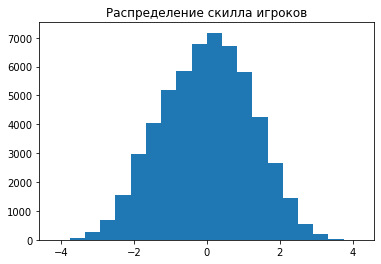

In [17]:
plt.hist(rating[["strength"]].values, bins=20)
plt.title("Распределение скилла игроков")
plt.show()

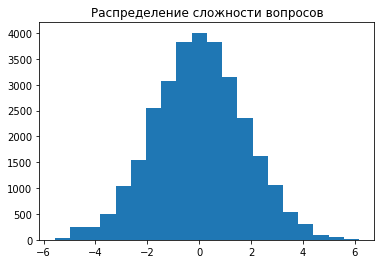

In [18]:
plt.hist(log_reg.coef_[0][len(all_pl):], bins=20)
plt.title("Распределение сложности вопросов")
plt.show()

In [19]:
log_reg.coef_[0][len(all_pl):].mean()

-9.827772831077906e-05

In [20]:
middle_question = np.abs(log_reg.coef_[0][len(all_pl):]).min()

question_index = np.where(log_reg.coef_[0][len(all_pl):] == middle_question)

middle_question = ohe_questions.categories_[0][question_index[0][0]]

In [21]:
test_info = []

for idx in tqdm(df_test_tournaments.index):
    tournament_results = results[idx]
    total_questions = set()
    
    mask = ""
    
    data_tournament_results = []
    
    for team in results[idx]:
        if team.get('mask') is not None:
            total_questions.add(len(team['mask'].replace("?", "").replace("X", "")))

    if len(total_questions) > 1:
        continue
        
    for team in tournament_results:
        info = {}
        if team.get("mask") is None or team.get("teamMembers") is None:
            continue
        if team["teamMembers"] == []:
            continue
        
        mask = team["mask"].replace("?", "").replace("X", "")
        info["tournament_id"] = idx
        info["team_id"] = team.get("team").get("id")
        info["mask"] = list(map(int, mask))
        info["players_id"] = []
        info["position"] = team["position"]
        players = team["teamMembers"]
        
        for player in players:
            info["players_id"].append(player["player"]["id"])
        
        data_tournament_results.append(info)
    if mask:
        test_info.append(data_tournament_results)

100%|██████████| 418/418 [00:00<00:00, 2062.25it/s]


Используя модель из предыдущего пункта, предсказываем вероятность ответа каждого игрока в команде на выбранный "средний" вопрос. После чего усредняем полученные вероятности. Это и будет рейтингом команды на каждом турнире.

In [22]:
test_results = {}

for tourn in tqdm(test_info):
    tournament_results = {}
    for team_in_tourn in tourn:
        ground_true = team_in_tourn["position"]
        team_members = []
        for player_id in team_in_tourn["players_id"]:
            try:
                ohe_players.transform([[player_id]])
                team_members.append(player_id)
            except ValueError:
                continue   
        if len(team_members) == 0:
            continue
        players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
        question_matrix = ohe_questions.transform(np.full((len(team_members), 1), middle_question))
        x = hstack([players_matrix, question_matrix])
        pred = log_reg.predict_proba(x)[:, 1]
        team_skill = pred.mean()
        tournament_results[team_in_tourn["team_id"]] = (team_skill, ground_true)
    test_results[tourn[0]["tournament_id"]] = tournament_results

100%|██████████| 165/165 [02:25<00:00,  1.14it/s]


In [23]:
spearman_correlations = []
kendall_correlations = []

for tourn in test_results.values():
    prediction = []
    ground_true = []
    for team_stats in tourn.values():
        prediction.append(team_stats[0])
        ground_true.append(team_stats[1])
    spearman_corr = spearmanr(prediction, ground_true)[0]
    spearman_correlations.append(spearman_corr)
    kendall_corr = kendalltau(prediction, ground_true)[0]
    kendall_correlations.append(kendall_corr)

spearman_corr = np.mean([t for t in spearman_correlations if np.isfinite(t)])
kendall_corr = np.mean([t for t in kendall_correlations if np.isfinite(t)])

print(f"Spearman correlation: {np.abs(spearman_corr)}")
print(f"Kendall correlation: {np.abs(kendall_corr)}")

Spearman correlation: 0.7668936750917678
Kendall correlation: 0.6136993417857722


Корреляции в пределах нормы)

Попробуем по-другому считать скилл команды. Будем считать вероятность правильного ответа команды на "средний" вопрос по формуле: $TeamSkill = 1 - \prod\limits_{i \in team} (1 - \sigma [skill_i, MiddleQuestion])$, здесь team - список игроков в команде.

In [26]:
test_results = {}

for tourn in tqdm(test_info):
    tournament_results = {}
    for team_in_tourn in tourn:
        ground_true = team_in_tourn["position"]
        team_members = []
        for player_id in team_in_tourn["players_id"]:
            try:
                ohe_players.transform([[player_id]])
                team_members.append(player_id)
            except ValueError:
                continue   
        if len(team_members) == 0:
            continue
        players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
        question_matrix = ohe_questions.transform(np.full((len(team_members), 1), middle_question))
        x = hstack([players_matrix, question_matrix])
        pred = log_reg.predict_proba(x)[:, 1]
        team_skill = 1 - np.product(1 - pred)
        tournament_results[team_in_tourn["team_id"]] = (team_skill, ground_true)
    test_results[tourn[0]["tournament_id"]] = tournament_results

spearman_correlations = []
kendall_correlations = []

for tourn in test_results.values():
    prediction = []
    ground_true = []
    for team_stats in tourn.values():
        prediction.append(team_stats[0])
        ground_true.append(team_stats[1])
    spearman_corr = spearmanr(prediction, ground_true)[0]
    spearman_correlations.append(spearman_corr)
    kendall_corr = kendalltau(prediction, ground_true)[0]
    kendall_correlations.append(kendall_corr)

spearman_corr = np.mean([t for t in spearman_correlations if np.isfinite(t)])
kendall_corr = np.mean([t for t in kendall_correlations if np.isfinite(t)])

print(f"Spearman correlation: {np.abs(spearman_corr)}")
print(f"Kendall correlation: {np.abs(kendall_corr)}")

100%|██████████| 165/165 [02:20<00:00,  1.17it/s]


Spearman correlation: 0.7818445993308158
Kendall correlation: 0.6244028341644414


Метрики улучшились, что радует.

## 4 task

        Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


### EM схема:

* E-шаг: находим мат. ожидания $z_i{}_j$ (мат. ожидание того, что игрок i правильно ответил на вопрос j). 

1) $E[z_i{}_j] = 0$, если вся команда не ответила на вопрос $j$.

2) $E[z_i{}_j] = \frac{\sigma [skill_i, question_j]}{1 - \prod\limits_{n \in team} (1 - \sigma [skill_n, question_j])}$, если комада ответила на вопрос $j$. 

Формулу из п.2 получаем по теореме Байеса: 

Пусть событие A - команда правильно ответила на вопрос. Тогда событие B - игрок из команды правильно ответил на вопрос.

$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$; $P(A|B) = 1$ (если игрок ответил на вопрос, то и комада ответила на вопрос). В таком случае: $P(B|A) = \frac{P(B)}{P(A)}$

* M-шаг: пересчитываем параметры логистической регрессии, используя новые z.

In [24]:
def calculate_scores(model):
    test_results = {}

    for tourn in tqdm(test_info):
        tournament_results = {}
        for team_in_tourn in tourn:
            ground_true = team_in_tourn["position"]
            team_members = []
            for player_id in team_in_tourn["players_id"]:
                try:
                    ohe_players.transform([[player_id]])
                    team_members.append(player_id)
                except ValueError:
                    continue   
            if len(team_members) == 0:
                continue
            players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
            question_matrix = ohe_questions.transform(np.full((len(team_members), 1), middle_question))
            x = hstack([players_matrix, question_matrix])
            pred = model.predict_proba(x)[:, 1]
            team_skill = 1 - np.product(1 - pred)
            tournament_results[team_in_tourn["team_id"]] = (team_skill, ground_true)
        test_results[tourn[0]["tournament_id"]] = tournament_results
    
    spearman_correlations = []
    kendall_correlations = []

    for tourn in test_results.values():
        prediction = []
        ground_true = []
        for team_stats in tourn.values():
            prediction.append(team_stats[0])
            ground_true.append(team_stats[1])
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)

    spearman_corr = np.abs(np.mean([t for t in spearman_correlations if np.isfinite(t)]))
    kendall_corr = np.abs(np.mean([t for t in kendall_correlations if np.isfinite(t)]))
    return spearman_corr, kendall_corr

In [28]:
def E_step(model, data, target):
    e_z = []
    predictions = model.predict_proba(data)[:, 1]
    start_index = 0
    for team_in_tourn in tqdm(train_info):
        team_size = len(team_in_tourn["players_id"])
        mask_size = len(team_in_tourn["mask"])
        team_preds = predictions[start_index : start_index + team_size * mask_size]
        
        team_answers = predictions[start_index: start_index + team_size * mask_size]
        true_team_answers = target[start_index: start_index + mask_size]
        team_answers = team_answers.reshape((-1, mask_size)).T
        
        p_z = 1 - np.prod(1 - team_answers, axis=1)
        team_answers = team_answers / p_z.reshape(-1, 1)
        
        team_answers = np.where(true_team_answers != 0, team_answers, 0)
        
        predictions[start_index: start_index + team_size * mask_size] = team_answers.T.reshape(-1) 
        start_index += team_size * mask_size   
    return predictions

def M_step(e_z, data):
    e_z = np.array(e_z)
    target_0 = np.full((data.shape[0], 1), 0)
    target_1 = np.full((data.shape[0], 1), 1)
    targets = np.vstack((target_0, target_1))
    x = vstack([data, data])
    sample_weights = np.hstack((1 - e_z, e_z))
    model = LogisticRegression(solver="saga")
    model.fit(x, targets, sample_weight=sample_weights)
    return model

In [35]:
ITERS = 6

all_models = []
model = log_reg
for i in range(ITERS):
    e_z = E_step(model, data, target)
    model = M_step(e_z, data)
    all_models.append(model)
    spearman_corr, kendall_corr = calculate_scores(model)
    print(f"Spearman correlation: {spearman_corr}")
    print(f"Kendall correlation: {kendall_corr}")

100%|██████████| 165/165 [02:14<00:00,  1.23it/s]


Spearman correlation: 0.7873983488367624
Kendall correlation: 0.6300923615664483


100%|██████████| 165/165 [02:13<00:00,  1.24it/s]


Spearman correlation: 0.7879829426089304
Kendall correlation: 0.6313977471275035


100%|██████████| 165/165 [02:12<00:00,  1.24it/s]


Spearman correlation: 0.7869401650993217
Kendall correlation: 0.6306448340133608


100%|██████████| 165/165 [02:13<00:00,  1.23it/s]


Spearman correlation: 0.7864515931556253
Kendall correlation: 0.6309317124418575


100%|██████████| 165/165 [02:29<00:00,  1.10it/s]


Spearman correlation: 0.7877339322249665
Kendall correlation: 0.6318202846778358


100%|██████████| 165/165 [02:14<00:00,  1.23it/s]


Spearman correlation: 0.787713188814873
Kendall correlation: 0.6312800688047152


Метрики улучшились относительно бейзлайна!

In [36]:
best_model = all_models[4]

## 5 task

        А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

Усредним сложности вопросов в каждом турнире, используя лучшую модель из предыдущего пункта. Таким образом и получим рейтинг турниров.

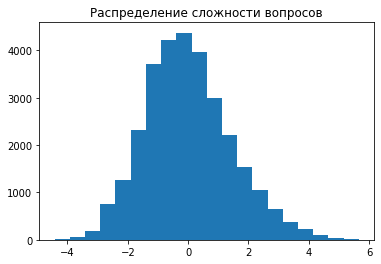

In [37]:
plt.hist(all_models[4].coef_[0][len(all_pl):], bins=20)
plt.title("Распределение сложности вопросов")
plt.show()

In [38]:
tournaments_with_quest_size = [[train_info[0]["tournament_id"], len(train_info[0]["mask"])]]
for team_in_tourn in train_info:
    tournament_id = team_in_tourn["tournament_id"]
    mask_size = len(team_in_tourn["mask"])
    if tournaments_with_quest_size[-1] != [tournament_id, mask_size]:
        tournaments_with_quest_size.append([tournament_id, mask_size])

In [39]:
qustions_difficulties = model.coef_[0][len(all_pl):]
tournaments_difficulties = []
i = 0
for tourn in tournaments_with_quest_size:
    diff_in_tourn = np.array(qustions_difficulties[i : i + tourn[1]])
    tournaments_difficulties.append([tourn[0], np.mean(diff_in_tourn)])
    i += tourn[1]

In [40]:
top_hardest = np.array(sorted(tournaments_difficulties, key=lambda x: x[1]))
top_easiest = np.array(sorted(tournaments_difficulties, key=lambda x: x[1], reverse=True))

In [41]:
pd_top_hardest = pd.DataFrame(df_train_tournaments.loc[top_hardest[:, 0]].name)
pd_top_easiest = pd.DataFrame(df_train_tournaments.loc[top_easiest[:, 0]].name)

__Топ самых легких турниров__

In [42]:
pd_top_easiest.head(20)

,name
id,
5013.0,(а)Синхрон-lite. Лига старта. Эпизод V
5438.0,Синхрон Лиги Разума
5702.0,(а)Синхрон-lite. Лига старта. Эпизод IX
5009.0,(а)Синхрон-lite. Лига старта. Эпизод III
5698.0,(а)Синхрон-lite. Лига старта. Эпизод VII
5313.0,(а)Синхрон-lite. Лига старта. Эпизод VI
5704.0,(а)Синхрон-lite. Лига старта. Эпизод X
6003.0,Второй тематический турнир имени Джоуи Триббиани
5011.0,(а)Синхрон-lite. Лига старта. Эпизод IV


__Топ самых сложных турниров__

In [43]:
pd_top_hardest.head(20)

,name
id,
6149.0,Чемпионат Санкт-Петербурга. Первая лига
5928.0,Угрюмый Ёрш
5159.0,Первенство правого полушария
5684.0,Синхрон высшей лиги Москвы
5025.0,Кубок городов
5465.0,Чемпионат России
6101.0,Воображаемый музей
5942.0,Чемпионат Мира. Этап 2. Группа В
5587.0,Записки охотника


По названиям турниров вроде как все сходится.